In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the path to the CSV file
path = 'data/parse_2024-06-05_09-13-00.csv'
ordered_columns = ['active', 'repaid', 'forced-liquidation', 'self-liquidation']

# Create a mapping dictionary for the labels
label_mapping = {
    'weth': 'crvusd:weth',
    'wsteth': 'crvusd:wsteth',
    'wbtc': 'crvusd:wbtc',
    'sfrxeth': 'crvusd:sfrxeth',
    'tbtc': 'crvusd:tbtc',
    'll_0': 'll:wsteth-long',
    'll_1': 'll:weth-long',
    'll_2': 'll:tbtc-long',
    'll_3': 'll:crv-long',
    'll_4': 'll:crv-short',
    'll_5': 'll:weth-short',
    'll_6': 'll:tbtc-short',
    'll_7': 'll:methena',
    'll_8': 'll:uwu-long',
    'll_9': 'll:wbtc-long',
    'll_10': 'll:pufeth-long'
}
# Load the CSV file into a DataFrame
summary_df = pd.read_csv(path)
summary_df.head()

,Address,Asset,Start_Block,Status,End_Block
0,0x7a16ff8270133f063aab6c9977183d9e72835428,wsteth,17432234,repaid,18647481.0
1,0x7a16ff8270133f063aab6c9977183d9e72835428,sfrxeth,18001239,forced-liquidation,18142320.0
2,0x7a16ff8270133f063aab6c9977183d9e72835428,tbtc,18001359,self-liquidation,19087064.0
3,0x7a16ff8270133f063aab6c9977183d9e72835428,ll_3,19425629,active,NaN
4,0x7a16ff8270133f063aab6c9977183d9e72835428,ll_8,19872526,active,NaN


In [3]:
status_counts = summary_df['Status'].value_counts()

print(f"Stats cover {status_counts.sum()} loans from blocks", summary_df['Start_Block'].max(), "to", summary_df['End_Block'].max())

Stats cover 4368 loans from blocks 20026579 to 20019414.0


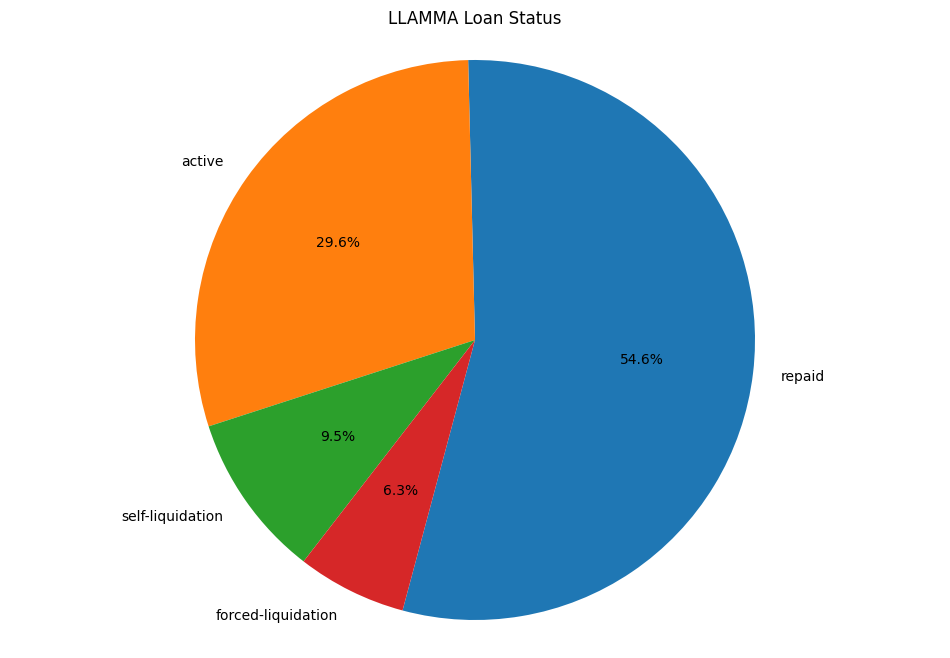

In [4]:
# Pie
plt.figure(figsize=(12, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=255)
plt.title('LLAMMA Loan Status')
plt.axis('equal') 
plt.show()


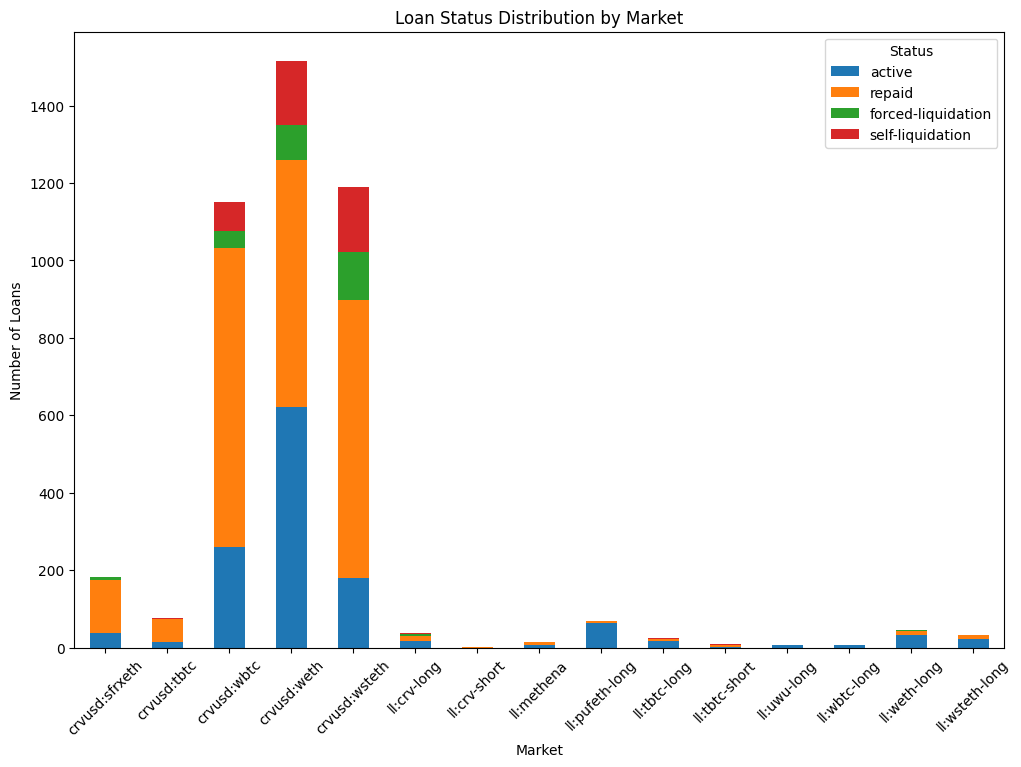

In [5]:
# Clearer labels
edited_df = summary_df.copy()
edited_df['Asset'] = edited_df['Asset'].map(label_mapping)

# Summarize the data by the new 'Asset' and 'Status'
market_status_counts_aggregated = edited_df.groupby(['Asset', 'Status']).size().unstack(fill_value=0)

# Reorder the columns to match the specified order
market_status_counts_aggregated = market_status_counts_aggregated.reindex(columns=ordered_columns, fill_value=0)

# Plot the stacked bar chart with the specified order and aggregated labels
market_status_counts_aggregated.plot(kind='bar', stacked=True, figsize=(12, 8), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title('Loan Status Distribution by Market')
plt.xlabel('Market')
plt.ylabel('Number of Loans')
plt.legend(title='Status')
plt.xticks(rotation=45)
plt.show()


<Figure size 2400x800 with 0 Axes>

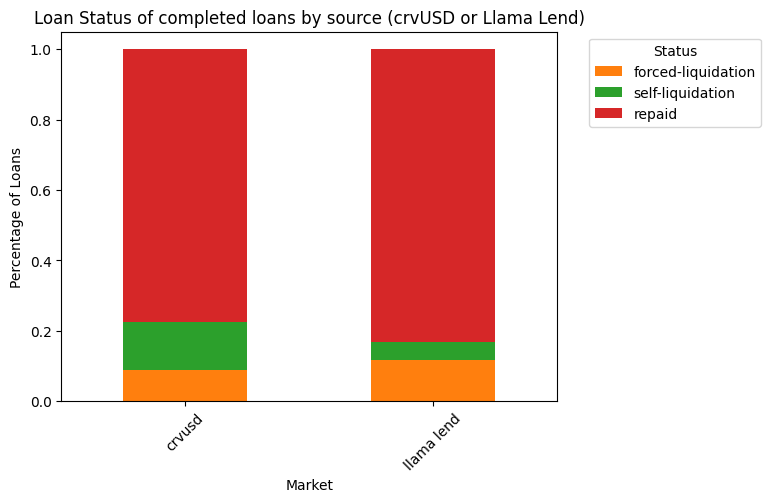

In [6]:
closed_df = summary_df.copy()
closed_df['Asset'] = closed_df['Asset'].map(label_mapping)

# Consolidate all crvusd markets into one
closed_df['Asset'] = closed_df['Asset'].apply(lambda x: 'crvusd' if x.startswith('crvusd:') else 'llama lend')

# Summarize the data by the new 'Asset' and 'Status'
market_status_counts_aggregated = closed_df.groupby(['Asset', 'Status']).size().unstack(fill_value=0)

# Drop the "active" column and reorder the columns to match the specified order
ordered_columns = ['forced-liquidation', 'self-liquidation', 'repaid']
market_status_counts_aggregated = market_status_counts_aggregated.drop(columns='active')
market_status_counts_aggregated = market_status_counts_aggregated.reindex(columns=ordered_columns, fill_value=0)

# Normalize the data to 100%
market_status_counts_normalized = market_status_counts_aggregated.div(market_status_counts_aggregated.sum(axis=1), axis=0)

# Plot the normalized to 100% stacked bar chart
plt.figure(figsize=(24, 8))
ax = market_status_counts_normalized.plot(kind='bar', stacked=True, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Loan Status of completed loans by source (crvUSD or Llama Lend)')
plt.xlabel('Market')
plt.ylabel('Percentage of Loans')
plt.xticks(rotation=45)
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



In [7]:
# Get band data for loans scraped from script 3 (slow!)

# Load the CSV file into a DataFrame
file_path = 'data/data_prod/liquidations.csv'
liq_df = pd.read_csv(file_path).dropna().drop_duplicates(subset='i', keep='first')
liq_df.head()

,i,user,block,current_band,health_values,lower_band_p,upper_band_p,lower_band,upper_band,user_state_calc,user_state_1,user_state_2,user_state_3,user_state_4
0,0,0x7a16ff8270133f063aab6c9977183d9e72835428,17259975,0.0,61.777612,1378.777215,1272.259360,40.0,49.0,0.0,929933909709140155529,0,1000000000000000000000000,10.0
50,1,0x2761a575cf6ea58d9d59426f1733df573d92cf36,17327256,-2.0,3.776146,2081.858075,1921.023493,-1.0,8.0,0.0,96059522344271474,0,157414457538017780587,10.0
100,2,0x2761a575cf6ea58d9d59426f1733df573d92cf36,17432369,-1.0,49.306138,1640.284151,1513.563497,33.0,42.0,0.0,62510480778504168579,0,80000000000000000000000,10.0
150,3,0x2761a575cf6ea58d9d59426f1733df573d92cf36,18200057,14.0,57.479739,1341.599786,1314.901951,53.0,56.0,0.0,137468192275538087666,0,150000000000000000000000,4.0
200,4,0x2761a575cf6ea58d9d59426f1733df573d92cf36,18352344,16.0,3.642411,1926.442164,1888.105964,17.0,20.0,0.0,187374994891732496504,0,295745144805563698187550,4.0


In [8]:
nonliq_path = 'data/data_prod/nonliquidations.csv'
nonliq_df = pd.read_csv(nonliq_path).dropna().drop_duplicates(subset='i', keep='first')

nonliq_df = nonliq_df.rename(columns={
    'times': 'block',
    'amm_prices': 'current_band',
    'us4': 'user_state_4'
})
nonliq_df.head()

,i,user,block,current_band,health_values,lower_band_p,upper_band_p,lower_band,upper_band,user_state_calc,us1,us2,us3,user_state_4
0,0,0x7a16ff8270133f063aab6c9977183d9e72835428,17432234,-1.0,3.310444,2286.390356,2109.754570,0.0,9.0,0.0,305268629225803740014,0,545893717570494761231379,10.0
10,1,0x7a16ff8270133f063aab6c9977183d9e72835428,19425629,-2.0,5.445410,0.892672,0.345494,-1.0,28.0,0.0,330000000000000000000000,0,158736484235628261162269,30.0
20,2,0x7a16ff8270133f063aab6c9977183d9e72835428,19872526,-1.0,29.254748,2.560643,1.102273,3.0,12.0,0.0,12844240129953808251391,0,15086973678499902634663,10.0
30,3,0x7a16ff8270133f063aab6c9977183d9e72835428,19925103,0.0,4.891565,3659.750773,1834.433386,6.0,55.0,0.0,7294313698987241859,0,17931257444801299393795,50.0
40,4,0x7a16ff8270133f063aab6c9977183d9e72835428,19939646,0.0,4.837323,4227.324082,2118.926919,7.0,56.0,0.0,25929862619793340980,0,73653969483118991199184,50.0


In [9]:
nonliq_grouped_counts = nonliq_df.groupby('user_state_4').nunique()['i'].reset_index(name='count_nonliq')
liq_grouped_counts = liq_df.groupby('user_state_4').nunique()['i'].reset_index(name='count_liq')

# Merge the results for comparison
grouped_counts = pd.merge(nonliq_grouped_counts, liq_grouped_counts, on='user_state_4', how='outer').fillna(0)

grouped_counts['pct'] = (grouped_counts['count_liq'] / (grouped_counts['count_liq'] + grouped_counts['count_nonliq']) )
def categorize_tier(n):
    if n == 4:
        return '4'
    elif 5 <= n <= 9:
        return '5-9'
    elif n == 10:
        return '10'
    elif n >= 11:
        return '11+'
    else:
        return 'Unknown'

grouped_counts['tier'] = grouped_counts['user_state_4'].apply(categorize_tier)

# Group by 'tier' and summarize the counts and percentages
tiered_counts = grouped_counts.groupby('tier').agg({
    'count_nonliq': 'sum',
    'count_liq': 'sum'
}).reset_index()

tiered_counts['pct'] = tiered_counts['count_liq'] / (tiered_counts['count_liq'] + tiered_counts['count_nonliq'])
tier_order = ['4', '5-9', '10', '11+']
tiered_counts['tier'] = pd.Categorical(tiered_counts['tier'], categories=tier_order, ordered=True)
tiered_counts = tiered_counts.sort_values('tier').reset_index(drop=True)

#grouped_counts
tiered_counts


,tier,count_nonliq,count_liq,pct
0,4,1551,501.0,0.244152
1,5-9,137,35.0,0.203488
2,10,1679,179.0,0.096340
3,11+,259,28.0,0.097561


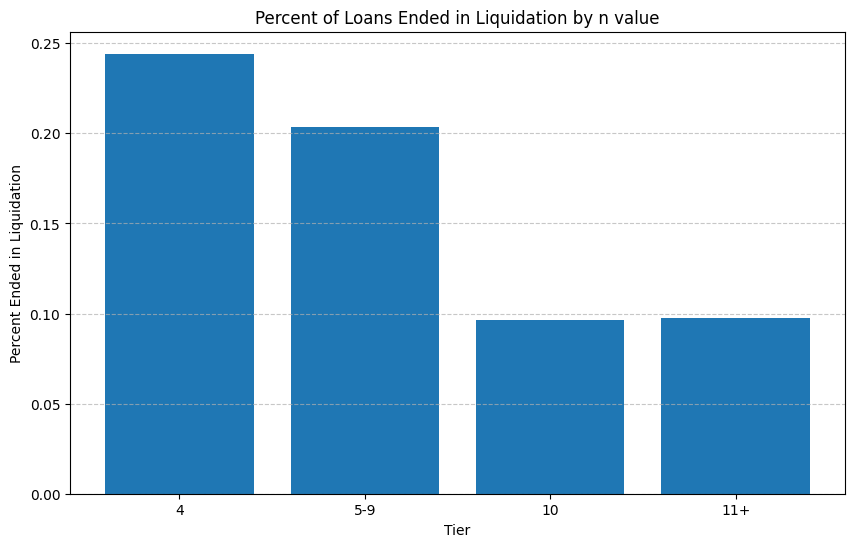

In [10]:
import matplotlib.pyplot as plt

# Plot the 'pct' column
plt.figure(figsize=(10, 6))
plt.bar(tiered_counts['tier'], tiered_counts['pct'])#, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Tier')
plt.ylabel('Percent Ended in Liquidation')
plt.title('Percent of Loans Ended in Liquidation by n value')
#plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [11]:
nonliq_df['tier'] = nonliq_df['user_state_4'].apply(categorize_tier)
liq_df['tier'] = liq_df['user_state_4'].apply(categorize_tier)
nonliq_df

,i,user,block,current_band,health_values,lower_band_p,upper_band_p,lower_band,upper_band,user_state_calc,us1,us2,us3,user_state_4,tier
0,0,0x7a16ff8270133f063aab6c9977183d9e72835428,17432234,-1.0,3.310444,2286.390356,2109.754570,0.0,9.0,0.0,305268629225803740014,0,545893717570494761231379,10.0,10
10,1,0x7a16ff8270133f063aab6c9977183d9e72835428,19425629,-2.0,5.445410,0.892672,0.345494,-1.0,28.0,0.0,330000000000000000000000,0,158736484235628261162269,30.0,11+
20,2,0x7a16ff8270133f063aab6c9977183d9e72835428,19872526,-1.0,29.254748,2.560643,1.102273,3.0,12.0,0.0,12844240129953808251391,0,15086973678499902634663,10.0,10
30,3,0x7a16ff8270133f063aab6c9977183d9e72835428,19925103,0.0,4.891565,3659.750773,1834.433386,6.0,55.0,0.0,7294313698987241859,0,17931257444801299393795,50.0,11+
40,4,0x7a16ff8270133f063aab6c9977183d9e72835428,19939646,0.0,4.837323,4227.324082,2118.926919,7.0,56.0,0.0,25929862619793340980,0,73653969483118991199184,50.0,11+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36153,3621,0x2f062d9aa98209d2c79a744b0d4ef203d363b7d6,19953233,-5.0,48.182518,2791.628319,2182.458040,3.0,12.0,0.0,1155550410231651160,0,2500000000000000000000,10.0,10
36163,3622,0x7965b7113d5ad4adf9eb249d3fdc437915dbbe26,19953507,-5.0,128.834316,1871.225361,1462.899200,16.0,25.0,0.0,1347900000000000000,0,2000000000000000000000,10.0,10
36173,3623,0x426939ecca81b35702056f6127e7e236a44fb81d,19955634,-5.0,378700.810513,1.273114,0.995303,253.0,262.0,0.0,989001300761766575,0,1000000000000000000,10.0,10
36183,3624,0xa19b237df97aff4d9e3a15d0077c3d7d7eec7c6b,19956631,-5.0,757075.137648,0.646934,0.505765,275.0,284.0,0.0,1978002293499647332,0,1000000000000000000,10.0,10


In [12]:
liq_df

,i,user,block,current_band,health_values,lower_band_p,upper_band_p,lower_band,upper_band,user_state_calc,user_state_1,user_state_2,user_state_3,user_state_4,tier
0,0,0x7a16ff8270133f063aab6c9977183d9e72835428,17259975,0.0,61.777612,1378.777215,1272.259360,40.0,49.0,0.0,929933909709140155529,0,1000000000000000000000000,10.0,10
50,1,0x2761a575cf6ea58d9d59426f1733df573d92cf36,17327256,-2.0,3.776146,2081.858075,1921.023493,-1.0,8.0,0.0,96059522344271474,0,157414457538017780587,10.0,10
100,2,0x2761a575cf6ea58d9d59426f1733df573d92cf36,17432369,-1.0,49.306138,1640.284151,1513.563497,33.0,42.0,0.0,62510480778504168579,0,80000000000000000000000,10.0,10
150,3,0x2761a575cf6ea58d9d59426f1733df573d92cf36,18200057,14.0,57.479739,1341.599786,1314.901951,53.0,56.0,0.0,137468192275538087666,0,150000000000000000000000,4.0,4
200,4,0x2761a575cf6ea58d9d59426f1733df573d92cf36,18352344,16.0,3.642411,1926.442164,1888.105964,17.0,20.0,0.0,187374994891732496504,0,295745144805563698187550,4.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36900,738,0xf1c7f8e68c594a7b87dd3d22057fed15d7fb63d7,19432511,-2.0,98.963216,0.536674,0.409190,14.0,23.0,0.0,45000000000000000000000,0,17160000000000000000000,10.0,10
36950,739,0xb51074da03c55e79e3526cf6bbf31873443efc63,19458525,6.0,11.778265,0.657734,0.501492,8.0,17.0,0.0,21000000000000000000000,0,10000000000000000000000,10.0,10
37000,740,0x2453d84c91472feb2ff19d727cea3163e647fd33,19559276,6.0,47.339049,0.518785,0.395550,15.0,24.0,0.0,200000000000000000000000,0,75000000000000000000000,10.0,10
37050,741,0xb056b9a45f09b006ec7a69770a65339586231a34,19567206,9.0,87.948160,0.382365,0.291536,24.0,33.0,0.0,81373652731071836643317,0,23000000000000000000000,10.0,10


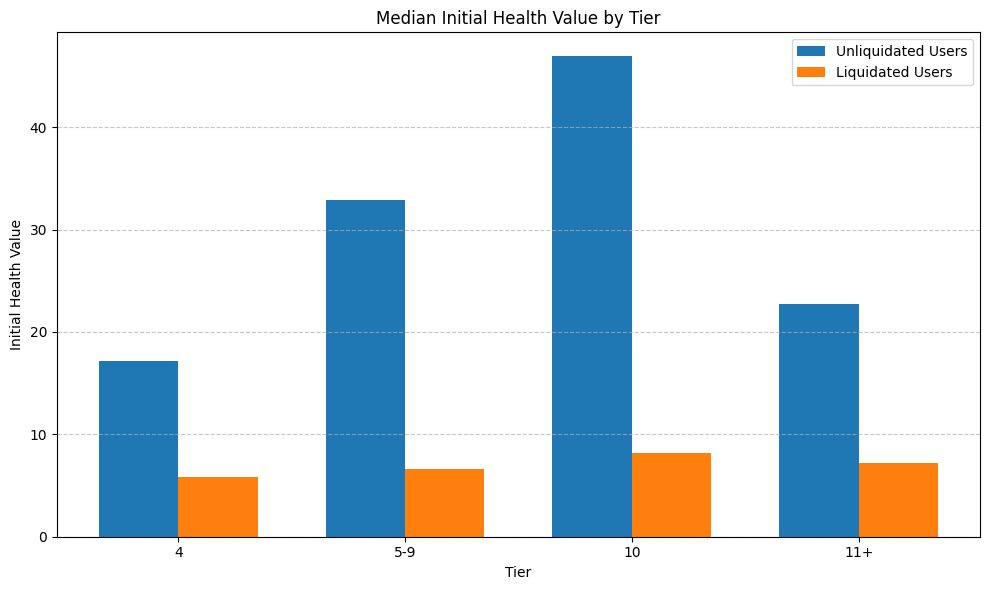

In [13]:

# Define a function to sort tiers
def sort_tiers(df):
    tier_order = ['4', '5-9', '10', '11+']
    df['tier'] = pd.Categorical(df['tier'], categories=tier_order, ordered=True)
    df = df.sort_values('tier').reset_index(drop=True)
    return df

# Group by 'tier' and calculate median initial health
unliq_health = sort_tiers(nonliq_df.groupby('tier')['health_values'].median().reset_index())
liq_health = sort_tiers(liq_df.groupby('tier')['health_values'].median().reset_index())

# Bar positions
x = np.arange(len(unliq_health['tier']))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, unliq_health['health_values'], width, label='Unliquidated Users')
rects2 = ax.bar(x + width/2, liq_health['health_values'], width, label='Liquidated Users')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tier')
ax.set_ylabel('Initial Health Value')
ax.set_title('Median Initial Health Value by Tier')
ax.set_xticks(x)
ax.set_xticklabels(unliq_health['tier'])
ax.legend()

# # Function to add labels
# def add_labels(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# add_labels(rects1)
# add_labels(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()

plt.show()


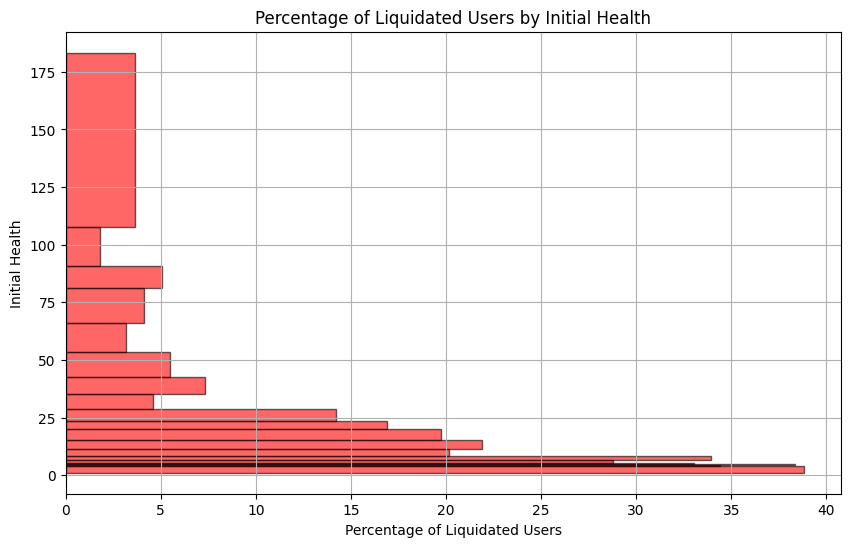

In [14]:
# Plot the horizontal bars representing each bin range
import numpy as np
nonliq_df['fate'] = 'unliquidated'
liq_df['fate'] = 'liquidated'

master_df = pd.concat([nonliq_df, liq_df], ignore_index=True)

# Calculate the bin edges such that 5% of users are within each bin
bin_edges = np.percentile(master_df['health_values'], np.arange(0, 101, 5))

# Drop the right-most bin edge
bin_edges = bin_edges[:-1]

# Bin the data based on these percentile-based edges
master_df['health_bin'] = pd.cut(master_df['health_values'], bins=bin_edges, include_lowest=True)

# Calculate the percentage of liquidated users within each bin
fate_by_health = master_df.groupby('health_bin')['fate'].value_counts(normalize=True).unstack().fillna(0)
fate_by_health['liquidated_percentage'] = fate_by_health['liquidated'] * 100

# Calculate the midpoints of each bin
bin_midpoints = bin_edges[:-1] + np.diff(bin_edges) / 2

# Plot the horizontal bars representing each bin range
plt.figure(figsize=(10, 6))

for i in range(len(bin_midpoints)):
    plt.barh(bin_midpoints[i], fate_by_health['liquidated_percentage'].iloc[i], 
             height=np.diff(bin_edges)[i], color='red', alpha=0.6, edgecolor='black')

plt.ylabel('Initial Health')
plt.xlabel('Percentage of Liquidated Users')
plt.title('Percentage of Liquidated Users by Initial Health')
plt.grid(True)
plt.show()

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df is already loaded and user_counts is calculated
user_counts = master_df['user'].value_counts()
frequency_summary = user_counts.value_counts().sort_index()

print(frequency_summary)


1     1851
2      445
3      168
4       69
5       44
6       21
7       12
8       11
9        3
10       5
11       3
12       1
13       1
15       3
17       2
23       1
28       1
65       1
Name: user, dtype: int64
